# Dataset A

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from tensorflow.keras.models import Model
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.applications.resnet50 import ResNet50
from sklearn.metrics import classification_report, confusion_matrix
from torchvision import transforms,datasets, models
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler, Subset
from torch import nn, optim
import torch.nn.functional as F
import time
import copy
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [20]:
directory_train = {
    'D:/MSc/SEMESTER 3/DL/LAB7/New folder/train/COVID19': 0,
    'D:/MSc/SEMESTER 3/DL/LAB7/New folder/train/Normal': 1,
    'D:/MSc/SEMESTER 3/DL/LAB7/New folder/train/Pneumonia': 2,
    'D:/MSc/SEMESTER 3/DL/LAB7/New folder/train/Turberculosis': 3
}


In [36]:
data_dir = r"D:/MSc/SEMESTER 3/DL/LAB7/New folder/train" 
dataset = datasets.ImageFolder(data_dir)

# Define split sizes
train_split = 0.7
val_split = 0.15
test_split = 0.15

# Shuffle & split the data
dataset_size = len(dataset)
indices = list(range(dataset_size))
np.random.shuffle(indices)

train_split_end = int(np.floor(train_split * dataset_size))
val_split_end = train_split_end + int(np.floor(val_split * dataset_size))

train_indices = indices[:train_split_end]
val_indices = indices[train_split_end:val_split_end]
test_indices = indices[val_split_end:]

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

train_transforms = transforms.Compose([
    transforms.Resize(64),
    transforms.RandomResizedCrop(64),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
data_transforms = {
    'train': train_transforms,
    'val': val_transforms,
}

# Apply transformations
train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = val_transforms
test_dataset.dataset.transform = val_transforms



In [37]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

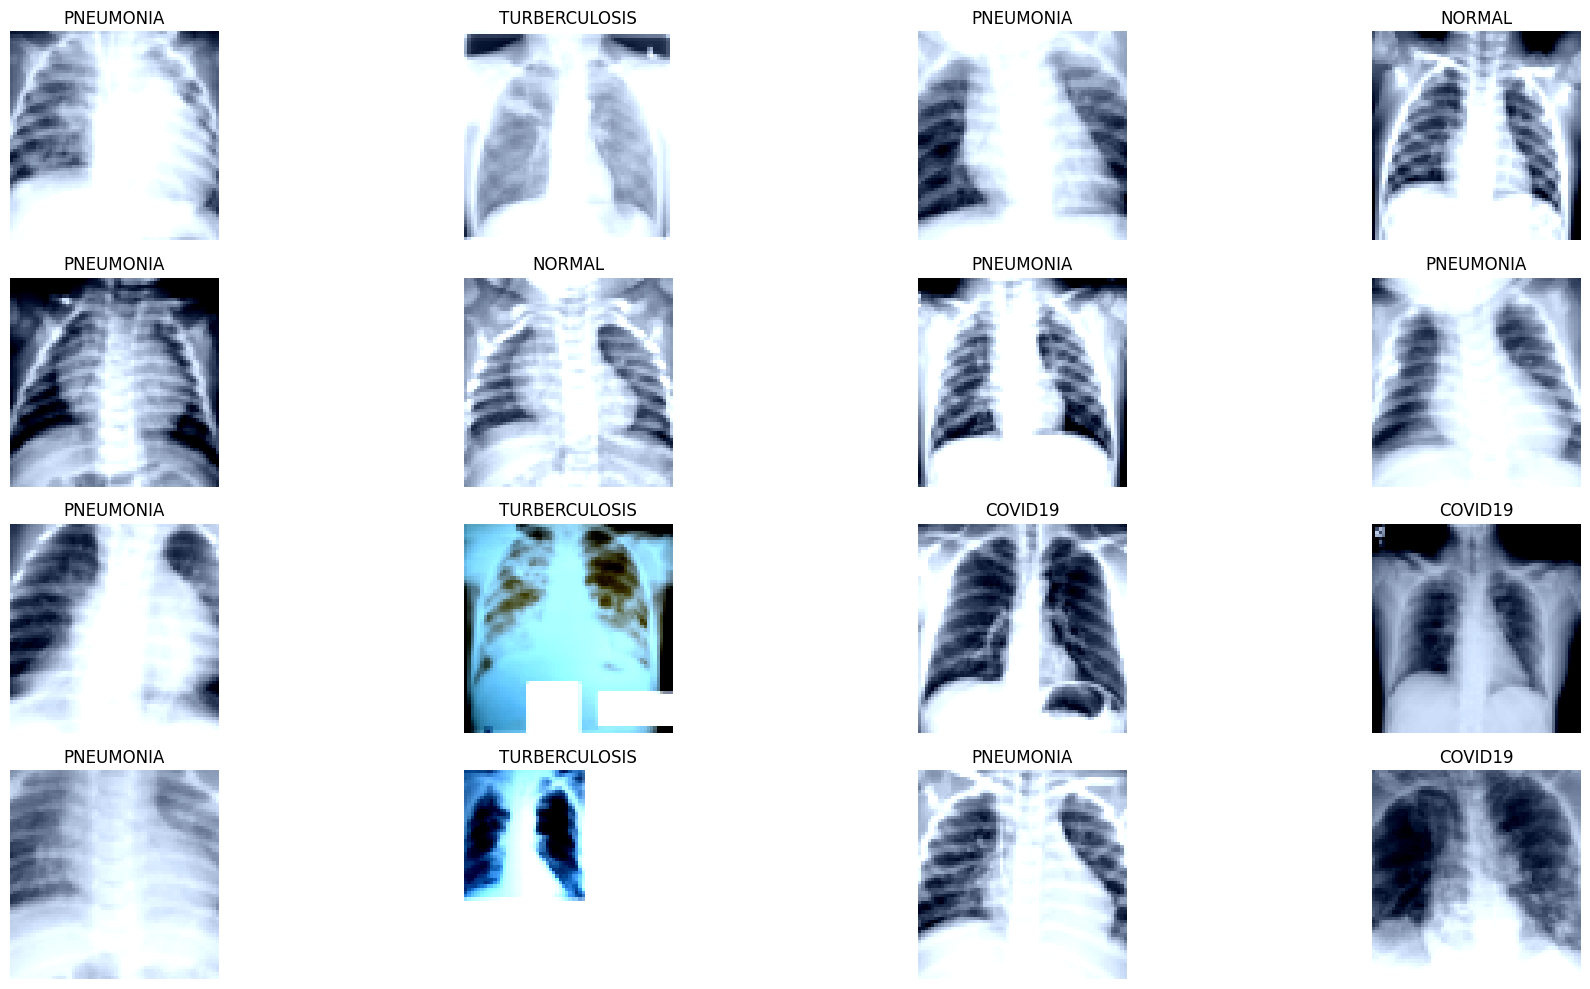

In [38]:
classes = dataset.classes  # This retrieves class names directly from your dataset

# Fetch a batch of images and labels from 'train_loader'
dataiter = iter(train_loader)
images, labels = next(dataiter)  

# Function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Display images
plt.figure(figsize=(20, 10))
for i in range(16):
    if i >= len(images):  # Check to prevent trying to display more images than available in the batch
        break
    plt.subplot(4, 4, i + 1)
    imshow(images[i])
    class_name = classes[labels[i]]  # Fetch the class name using the label as index
    plt.title(class_name, fontsize=12)

plt.tight_layout()
plt.show()

# Custom CNN architecture

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, num_classes=4):  
        super(CustomCNN, self).__init__()
        # Convolutional layers and pooling layer 
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        
        # Input image size
        input_size = 64

        # Calculate the output size after each convolutional layer and pooling
        conv1_output_size = ((input_size - 3 + 2 * 1) / 1) + 1  # (64 - 3 + 2*1) / 1 + 1 = 64
        pool1_output_size = conv1_output_size / 2  # Max pooling with kernel_size=2 and stride=2 halves the size
        conv2_output_size = ((pool1_output_size - 3 + 2 * 1) / 1) + 1  # (32 - 3 + 2*1) / 1 + 1 = 32
        pool2_output_size = conv2_output_size / 2  # Max pooling with kernel_size=2 and stride=2 halves the size

        # Update the input size for the first fully connected layer
        fc1_input_size = int(64 * pool2_output_size * pool2_output_size)  # 64 channels, pool2_output_size x pool2_output_size feature maps
        
        self.fc1 = nn.Linear(fc1_input_size, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)  
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model1 = CustomCNN(num_classes=4).to(device) 

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [42]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        running_loss = 0.0
        running_corrects = 0
        
        # Iterate over data
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            # Backward + optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        scheduler.step()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        print(f'Epoch {epoch}/{num_epochs - 1} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    
    return model

# Train the model
model1 = train_model(model1, criterion, optimizer, scheduler, num_epochs=10)

Epoch 0/9 Loss: 0.5447 Acc: 0.8704
Epoch 1/9 Loss: 0.1759 Acc: 0.9374
Epoch 2/9 Loss: 0.1327 Acc: 0.9553
Epoch 3/9 Loss: 0.1143 Acc: 0.9582
Epoch 4/9 Loss: 0.0923 Acc: 0.9652
Epoch 5/9 Loss: 0.0857 Acc: 0.9700
Epoch 6/9 Loss: 0.0779 Acc: 0.9718
Epoch 7/9 Loss: 0.0437 Acc: 0.9840
Epoch 8/9 Loss: 0.0362 Acc: 0.9860
Epoch 9/9 Loss: 0.0268 Acc: 0.9914


In [43]:
# Evaluate the model on the test set
def evaluate_model(model, criterion, dataloader):
    model.eval()  # Set model to evaluate mode
    
    running_loss = 0.0
    running_corrects = 0
    
    # Disabling gradient calculation is useful for inference
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass to calculate the output
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

            # Update the running loss and correct count
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
    
    # Calculate the loss and accuracy for the entire dataset
    total_loss = running_loss / len(dataloader.dataset)
    total_acc = running_corrects.double() / len(dataloader.dataset)

    print(f'Validation Loss: {total_loss:.4f} Acc: {total_acc:.4f}')

# Call the evaluate_model function
evaluate_model(model1, criterion, val_loader)

Validation Loss: 0.0965 Acc: 0.9715


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


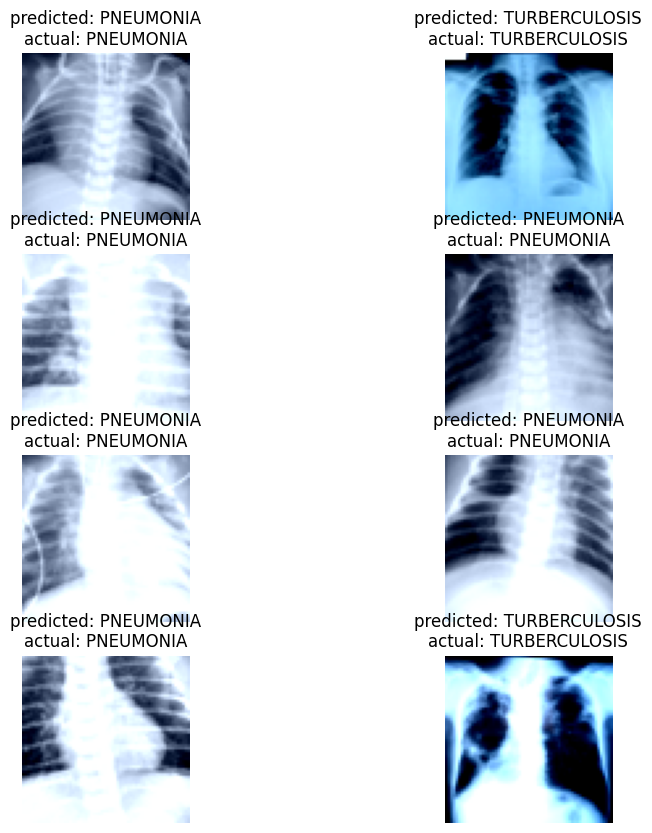

In [44]:
def visualize_model(model, num_images=8):
    was_training = model.training
    model.eval()
    images_so_far = 0
    plt.figure(figsize=(10, 10))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {classes[preds[j]]}\nactual: {classes[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

visualize_model(model1, num_images=8)


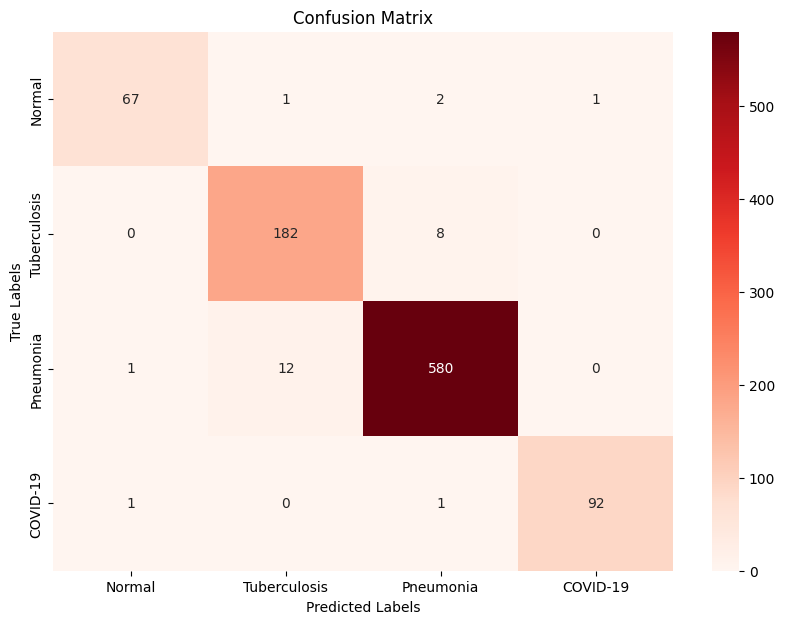

In [46]:
def get_predictions_and_labels(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    true_labels = []
    
    with torch.no_grad():  # We do not need gradient computation for this
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            predictions.extend(preds.view(-1).cpu().numpy())
            true_labels.extend(labels.view(-1).cpu().numpy())
    
    return np.array(predictions), np.array(true_labels)

# Using the function to get predictions and true labels
predictions, true_labels = get_predictions_and_labels(model1, val_loader)

class_names = ['Normal', 'Tuberculosis', 'Pneumonia', 'COVID-19']

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [47]:
print(classification_report(true_labels, predictions, target_names=class_names))

              precision    recall  f1-score   support

      Normal       0.97      0.94      0.96        71
Tuberculosis       0.93      0.96      0.95       190
   Pneumonia       0.98      0.98      0.98       593
    COVID-19       0.99      0.98      0.98        94

    accuracy                           0.97       948
   macro avg       0.97      0.96      0.97       948
weighted avg       0.97      0.97      0.97       948



# Restnet50

In [48]:
class CustomResNet50(nn.Module):
    def __init__(self, num_classes=4, dropout_probability=0.5):
        super(CustomResNet50, self).__init__()
        self.model = models.resnet50(pretrained=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_probability),
            nn.Linear(num_ftrs, num_classes)
        )

    def forward(self, x):
        return self.model(x)

model2 = CustomResNet50(num_classes=4, dropout_probability=0.5)

c:\Users\noelm\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\noelm\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\noelm/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:33<00:00, 3.11MB/s]


In [49]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model2.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) 

model2 = train_model(model2, criterion, optimizer, scheduler, num_epochs=10)


Epoch 0/9 Loss: 0.3102 Acc: 0.9018
Epoch 1/9 Loss: 0.1627 Acc: 0.9490
Epoch 2/9 Loss: 0.1196 Acc: 0.9632
Epoch 3/9 Loss: 0.0879 Acc: 0.9702
Epoch 4/9 Loss: 0.0908 Acc: 0.9709
Epoch 5/9 Loss: 0.0811 Acc: 0.9720
Epoch 6/9 Loss: 0.0687 Acc: 0.9781
Epoch 7/9 Loss: 0.0166 Acc: 0.9962
Epoch 8/9 Loss: 0.0096 Acc: 0.9968
Epoch 9/9 Loss: 0.0047 Acc: 0.9995


In [50]:
evaluate_model(model2, criterion, val_loader)

Validation Loss: 0.0917 Acc: 0.9715


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

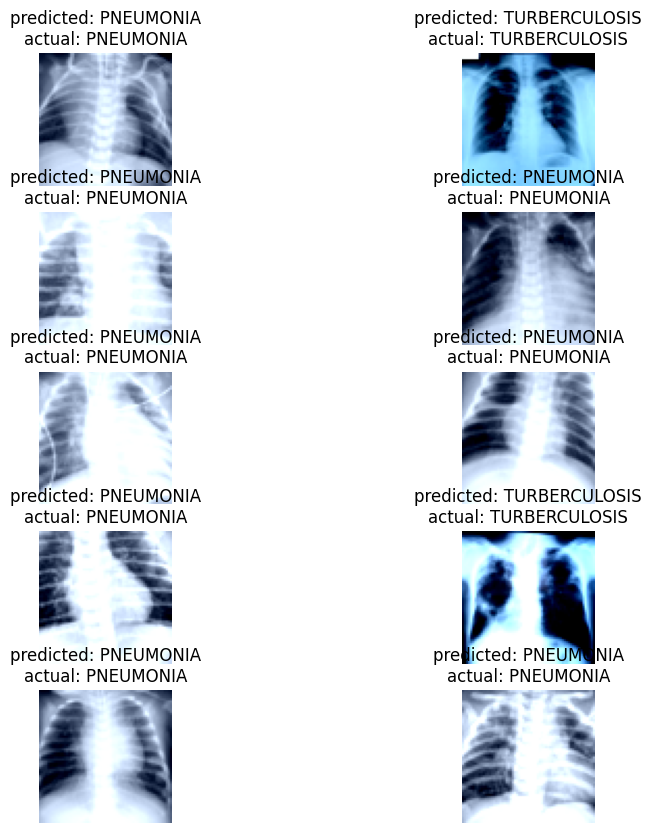

In [51]:
visualize_model(model2, num_images=10)

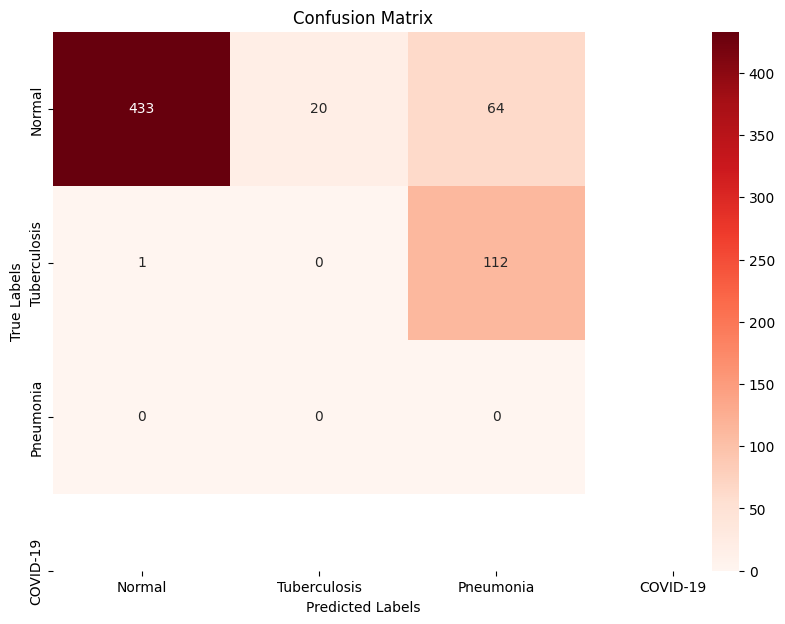

In [57]:
def get_predictions_and_labels(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    true_labels = []
    
    with torch.no_grad(): 
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            predictions.extend(preds.view(-1).cpu().numpy())
            true_labels.extend(labels.view(-1).cpu().numpy())
    
    return np.array(predictions), np.array(true_labels)

predictions, true_labels = get_predictions_and_labels(model2, val_loader)

class_names = ['Normal', 'Tuberculosis', 'Pneumonia', 'COVID-19']

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [54]:
print(classification_report(true_labels, predictions, target_names=class_names))

              precision    recall  f1-score   support

      Normal       0.90      0.97      0.93        71
Tuberculosis       0.95      0.95      0.95       190
   Pneumonia       0.98      0.98      0.98       593
    COVID-19       1.00      0.96      0.98        94

    accuracy                           0.97       948
   macro avg       0.96      0.97      0.96       948
weighted avg       0.97      0.97      0.97       948



# Dataset B


In [55]:
data_dir = r"D:/MSc/SEMESTER 3/DL/LAB7/TB_Chest_Radiography_Database" 
dataset = datasets.ImageFolder(data_dir)

# Define split sizes
train_split = 0.7
val_split = 0.15
test_split = 0.15

# Shuffle & split the data
dataset_size = len(dataset)
indices = list(range(dataset_size))
np.random.shuffle(indices)

train_split_end = int(np.floor(train_split * dataset_size))
val_split_end = train_split_end + int(np.floor(val_split * dataset_size))

train_indices = indices[:train_split_end]
val_indices = indices[train_split_end:val_split_end]
test_indices = indices[val_split_end:]

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

train_transforms = transforms.Compose([
    transforms.Resize(64),
    transforms.RandomResizedCrop(64),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
data_transforms = {
    'train': train_transforms,
    'val': val_transforms,
}

# Apply transformations
train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = val_transforms
test_dataset.dataset.transform = val_transforms



In [56]:
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']
test_dataset.dataset.transform = data_transforms['val'] 

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

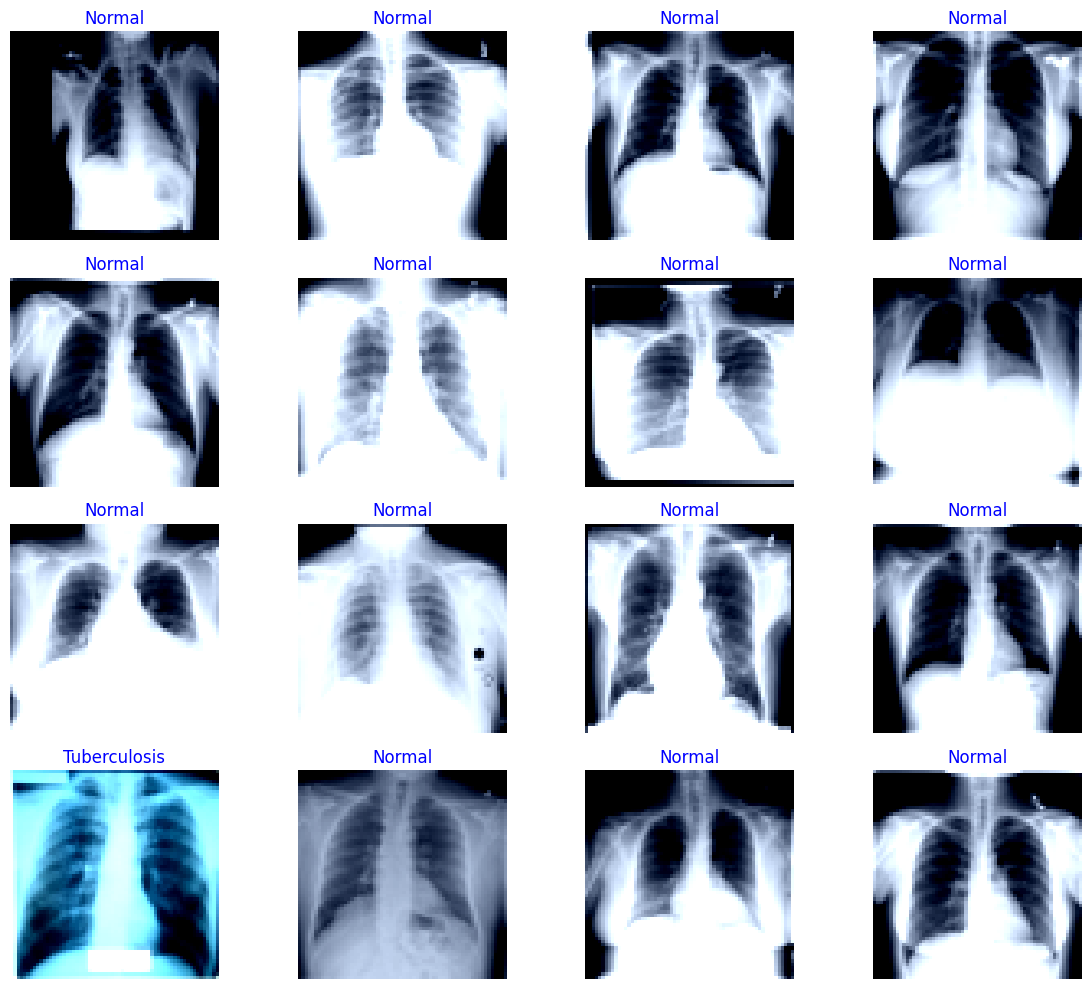

In [59]:
dataiter = iter(train_loader)
images, labels = next(dataiter)  

# Function to denormalize image for visualization
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.axis('off')

class_names = dataset.classes

plt.figure(figsize=(12, 10))

# Display 16 images from the batch
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    imshow(images[i])
    ax.set_title(class_names[labels[i]], color='blue', fontsize=12)

plt.tight_layout()
plt.show()

# Restnet50 model for datasetB

In [60]:
class CustomResNet50(nn.Module):
    def __init__(self, num_classes=2, dropout_probability=0.5):
        super(CustomResNet50, self).__init__()
        self.model = models.resnet50(pretrained=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_probability),
            nn.Linear(num_ftrs, num_classes)
        )

    def forward(self, x):
        return self.model(x)

model = CustomResNet50(num_classes=2, dropout_probability=0.5)

c:\Users\noelm\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\noelm\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [62]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) 

# Training Function
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        running_loss = 0.0
        running_corrects = 0
        
        # Iterate over data
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            # Backward + optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        scheduler.step()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        print(f'Epoch {epoch}/{num_epochs - 1} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    
    return model

# Train the model
model = train_model(model, criterion, optimizer, scheduler, num_epochs=5)

Epoch 0/4 Loss: 0.1248 Acc: 0.9582
Epoch 1/4 Loss: 0.0580 Acc: 0.9786
Epoch 2/4 Loss: 0.0652 Acc: 0.9779
Epoch 3/4 Loss: 0.1070 Acc: 0.9728
Epoch 4/4 Loss: 0.0880 Acc: 0.9724


In [63]:
def evaluate_model(model, criterion, dataloader):
    model.eval()  # Set model to evaluate mode
    
    running_loss = 0.0
    running_corrects = 0
    
    # Disabling gradient calculation is useful for inference
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass to calculate the output
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

            # Update the running loss and correct count
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
    
    # Calculate the loss and accuracy for the entire dataset
    total_loss = running_loss / len(dataloader.dataset)
    total_acc = running_corrects.double() / len(dataloader.dataset)

    print(f'Validation Loss: {total_loss:.4f} Acc: {total_acc:.4f}')

# Call the evaluate_model function
evaluate_model(model, criterion, val_loader)


Validation Loss: 0.0717 Acc: 0.9825


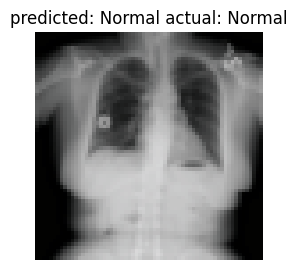

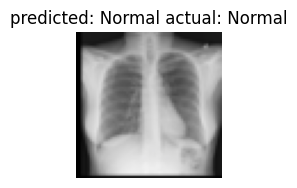

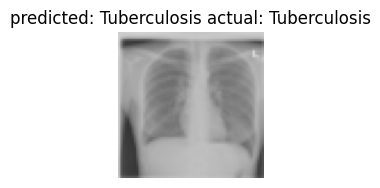

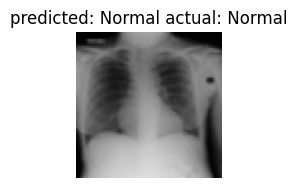

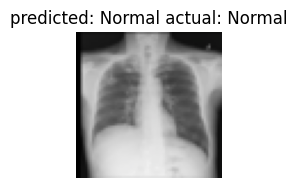

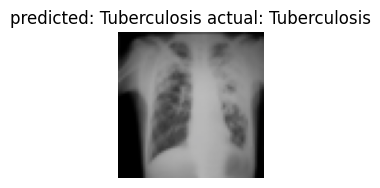

In [64]:
label_names = {0: 'Normal', 1: 'Tuberculosis'}

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(10, 7)) 

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 3, 3, images_so_far) 
                ax.axis('off')
                ax.set_title(f'predicted: {label_names[int(preds[j])]} actual: {label_names[int(labels[j])]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    plt.show()
                    return
        model.train(mode=was_training)

visualize_model(model, num_images=6)


[[509  16]
 [  4 101]]


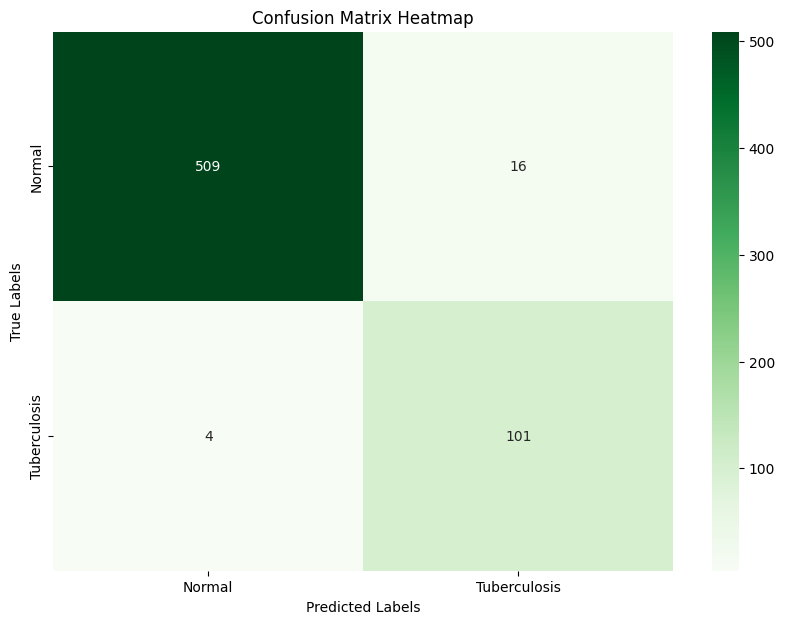

In [65]:
def get_all_preds_labels(model, loader):
    all_preds = []
    all_labels = []
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

all_preds, all_labels = get_all_preds_labels(model, test_loader)

cm = confusion_matrix(all_labels, all_preds)
print(cm)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=label_names.values(), yticklabels=label_names.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [66]:
print(classification_report(all_labels, all_preds, target_names=label_names.values()))

              precision    recall  f1-score   support

      Normal       0.99      0.97      0.98       525
Tuberculosis       0.86      0.96      0.91       105

    accuracy                           0.97       630
   macro avg       0.93      0.97      0.95       630
weighted avg       0.97      0.97      0.97       630



In [67]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 16 * 16)  # Flatten
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [68]:
model3 = CustomCNN().to(device)

# Loss and Optimizer
optimizer = optim.Adam(model3.parameters(), lr=0.001) 
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model3 = train_model(model3, criterion, optimizer, scheduler, num_epochs=5)

Epoch 0/4 Loss: 0.4658 Acc: 0.9350
Epoch 1/4 Loss: 0.0922 Acc: 0.9711
Epoch 2/4 Loss: 0.0753 Acc: 0.9779
Epoch 3/4 Loss: 0.0775 Acc: 0.9731
Epoch 4/4 Loss: 0.0499 Acc: 0.9850


In [69]:
evaluate_model(model3, criterion, val_loader)

Validation Loss: 0.0405 Acc: 0.9825


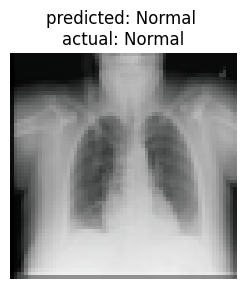

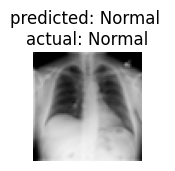

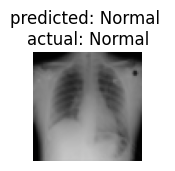

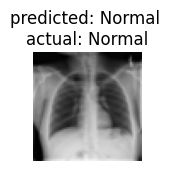

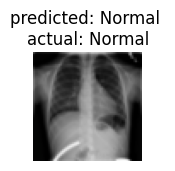

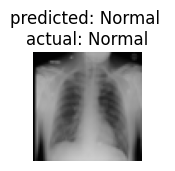

In [70]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def visualize_model_predictions(model, dataloader, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {label_names[preds[j].item()]} \nactual: {label_names[labels[j].item()]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

label_names = {0: 'Normal', 1: 'Tuberculosis'}

visualize_model_predictions(model3, val_loader, num_images=6)

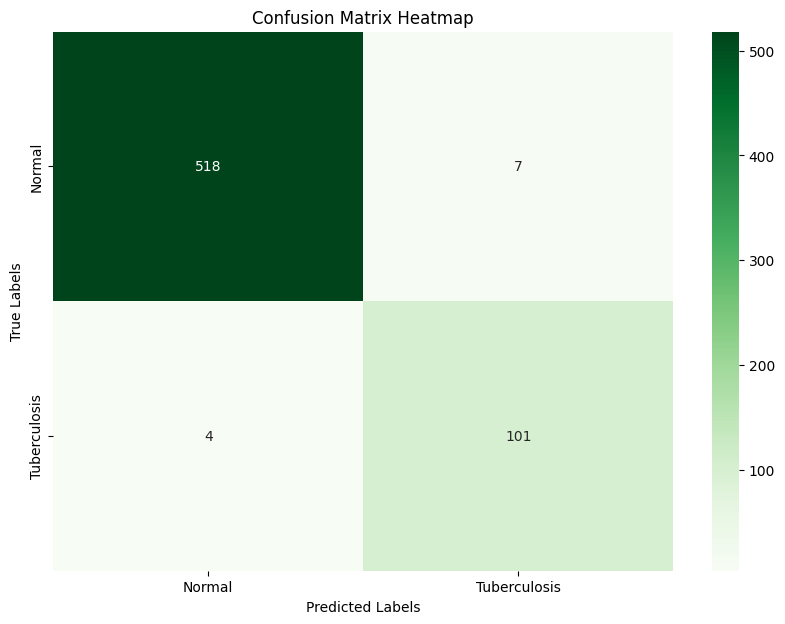

In [71]:
all_preds, all_labels = get_all_preds_labels(model3, test_loader)

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Greens', xticklabels=label_names.values(), yticklabels=label_names.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [72]:
print(classification_report(all_labels, all_preds, target_names=label_names.values()))

              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99       525
Tuberculosis       0.94      0.96      0.95       105

    accuracy                           0.98       630
   macro avg       0.96      0.97      0.97       630
weighted avg       0.98      0.98      0.98       630

